# TEP data analysis
In this notebook, we'll analyze the TEP extraction data. First, I've reformatted the data into a csv file that is easier to work with. The data consists of 3 replicates of TEP concentration measurements at 4 different stations, measured every hour for the longest possible time period depending on the weather and storm conditions. 

From the three replicates, the final TEP concentration is calculated as

$$TEP = (\frac{TEP_{1} + TEP_{2} + TEP_{3}}{3} - TEP_{blank}) * 56440 * 0,1$$

The blank that was taken at a given station is the first observation, and marked with _blank. Station 48 has no blank, so I added 0,1 as a blank value.


In [2]:
# Load necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

## Data pre-processing

In [3]:
data = pd.read_csv('../data/raw/TEP_data.csv', sep=';', decimal=',')
data.head()

,date,time,station,TEP_1,TEP_2,TEP_3
0,17-04-2023,13:00,W08_blank,0.087,0.113,0.129
1,17-04-2023,13:00,W08,0.260,0.262,0.262
2,17-04-2023,14:00,W08,0.131,0.181,0.190
3,17-04-2023,15:00,W08,0.141,0.193,0.220
4,17-04-2023,16:00,W08,0.123,0.146,0.208


In [4]:
def calculate_tep_concentration(tep_values, blank_avg, scale_factor=0.1):
    """
    Calculate the TEP concentration from replicate measurements of a sample and the average blank value taken at that station.

    Parameters:
        tep_values (list or tuple): Replicate measurements of TEP for the sample.
        blank_value (float): Mean of the replicate measurements of TEP for the blank.
        scale_factor (float, optional): The scaling factor for the final result (default is 0.1).

    Returns:
        float: The calculated TEP concentration.
    """
    # Calculate the average TEP values for sample and blank ignoring NaN values
    tep_avg = np.nanmean(tep_values)
    
    tep_concentration = (tep_avg - blank_avg) * 56440 * scale_factor
    return tep_concentration

In [5]:
# Extract the station name from 'station' column and create a new dataframe 'station_blank'
station_blank = data[data['station'].str.contains('blank')].copy()

# Calculate the mean TEP value of the blank stations
station_blank['TEP_avg'] = station_blank[['TEP_1', 'TEP_2', 'TEP_3']].mean(axis=1)

# Split _blank from the station name
station_blank['station'] = station_blank['station'].str.split('_blank').str[0]

# Remove the blanks from the original dataframe
data = data[~data['station'].str.contains('blank')]

# Reset the index of the original dataframe
data.reset_index(drop=True, inplace=True)

In [6]:
# Loop over the samples and add the calculated TEP to the dataframe
TEP = []
for i in range(len(data)):
    replicates = data.iloc[i][['TEP_1', 'TEP_2', 'TEP_3']].values
    blank = station_blank[station_blank['station'] == data.iloc[i]['station']]['TEP_avg'].astype(float).values[0]
    TEP.append(calculate_tep_concentration(tep_values = replicates, blank_avg = blank))
    
# Add the TEP values to the dataframe
data['TEP'] = TEP

In [7]:
# Merge date and time columns into one datetime column
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'], format='%d-%m-%Y %H:%M')

# Time is local time, so we need to convert it to UTC
data['datetime'] = data['datetime'] - pd.Timedelta(hours=2)

In [8]:
data.sort_values(by='TEP', ascending=False)

,date,time,station,TEP_1,TEP_2,TEP_3,TEP,datetime
53,20-04-2023,21:00,130,0.607,0.481,0.544,2250.074667,2023-04-20 19:00:00
48,20-04-2023,16:00,130,0.417,0.904,0.234,2105.212000,2023-04-20 14:00:00
46,20-04-2023,14:00,130,0.551,0.505,0.299,1728.945333,2023-04-20 12:00:00
60,21-04-2023,04:00,130,0.558,0.425,0.303,1599.133333,2023-04-21 02:00:00
50,20-04-2023,18:00,130,0.386,0.485,0.343,1463.677333,2023-04-20 16:00:00
...,...,...,...,...,...,...,...,...
13,18-04-2023,14:00,51,0.159,0.122,0.176,167.438667,2023-04-18 12:00:00
19,18-04-2023,20:00,51,0.111,0.171,0.172,161.794667,2023-04-18 18:00:00
34,19-04-2023,14:00,48,0.111,0.142,NaN,149.566000,2023-04-19 12:00:00
22,18-04-2023,23:00,51,0.129,0.150,0.166,144.862667,2023-04-18 21:00:00


In [9]:
# Export the data to a new csv file
data.to_csv('../data/analysis/TEP_data_processed.csv', index=False)

## Visualization

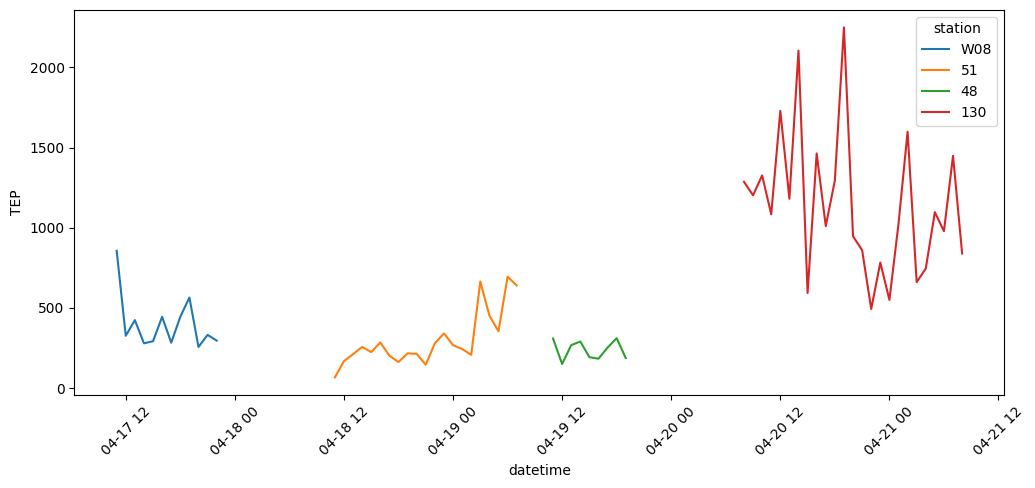

In [10]:
# Plot the average TEP concentration over time, coloured per station
## Initiate the plot
fig, ax = plt.subplots(figsize=(12, 5))
fig = sns.lineplot(x="datetime", y="TEP",
             hue="station",
             data=data)

# Adjust x axis labels
ax.tick_params(axis='x', rotation=45)

## Save the plot
fig.figure.savefig('../figures/TEP_concentration_over_time.png', bbox_inches='tight')

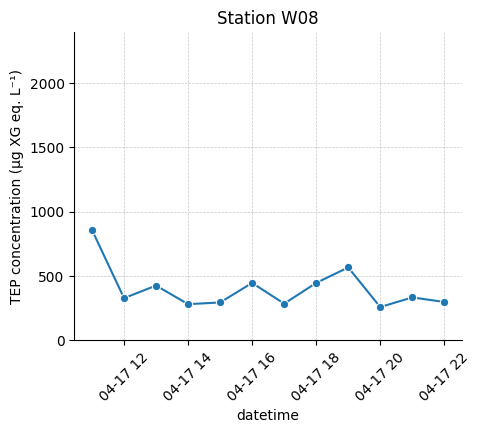

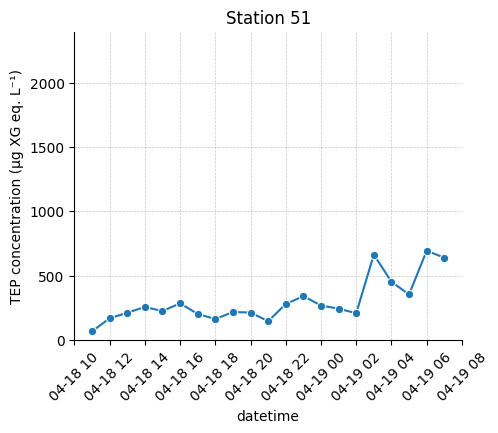

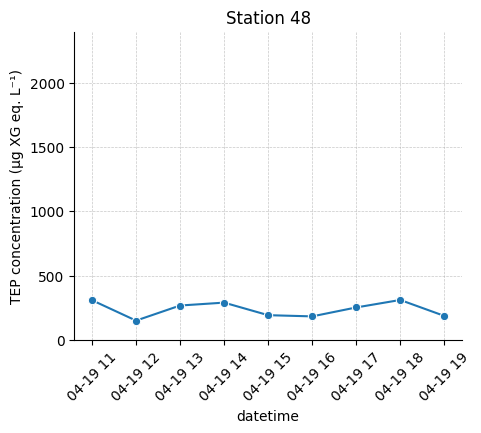

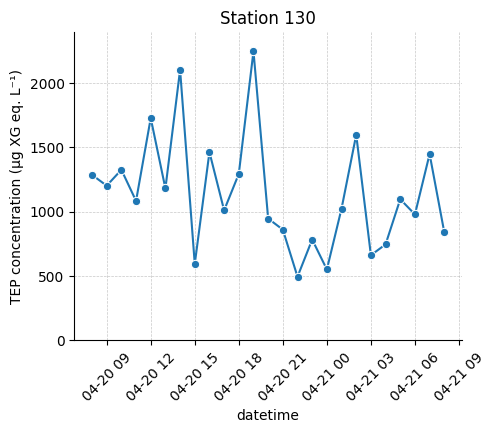

In [14]:
# Plot per station
stations = data['station'].unique()

for station in stations:
    fig, ax = plt.subplots(figsize=(5, 4))
    
    sns.lineplot(x="datetime", y="TEP", marker='o',
                 data=data[data['station'] == station], ax=ax)

    # Adjust x axis labels
    ax.tick_params(axis='x', rotation=45)
        
    # Set y axis limits
    ax.set(ylim=(0, 2400))
    
    # Set y axis label
    ax.set_ylabel('TEP concentration (µg XG eq. L⁻¹)')
    
    # Add title
    ax.set_title(f'Station {station}')
    
    # Remove outer box (spines)
    sns.despine(ax=ax)

    # Add light grid
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Save the plot
    fig.savefig(f'../figures/TEP_concentration_over_time_{station}.svg', bbox_inches='tight')
    fig.savefig(f'../figures/TEP_concentration_over_time_{station}.pdf', bbox_inches='tight')
    
    plt.show()

What is up with the data at station 130? Why these peaks and shifts? The variance is huge. Why?

In [22]:
# Plot the replicate TEP measurements per station, in 4 different plots. 
## Restructure the data, melt from wide to long format, with the columns: station, datetime, replicate, TEP
data_2 = data[['station', 'datetime', 'TEP_1', 'TEP_2', 'TEP_3']]
data_2 = data_2.melt(id_vars=['station', 'datetime'], value_vars=['TEP_1', 'TEP_2', 'TEP_3'], var_name='replicate', value_name='TEP')
data_2.head()

,station,datetime,replicate,TEP
0,W08,2023-04-17 11:00:00,TEP_1,0.260
1,W08,2023-04-17 12:00:00,TEP_1,0.131
2,W08,2023-04-17 13:00:00,TEP_1,0.141
3,W08,2023-04-17 14:00:00,TEP_1,0.123
4,W08,2023-04-17 15:00:00,TEP_1,0.136


In [23]:
# Divide the data into 4 dataframes, one for each station
df_130 = data_2[data_2['station'] == '130']
df_48 = data_2[data_2['station'] == '48']
df_51 = data_2[data_2['station'] == '51']
df_W08 = data_2[data_2['station'] == 'W08']

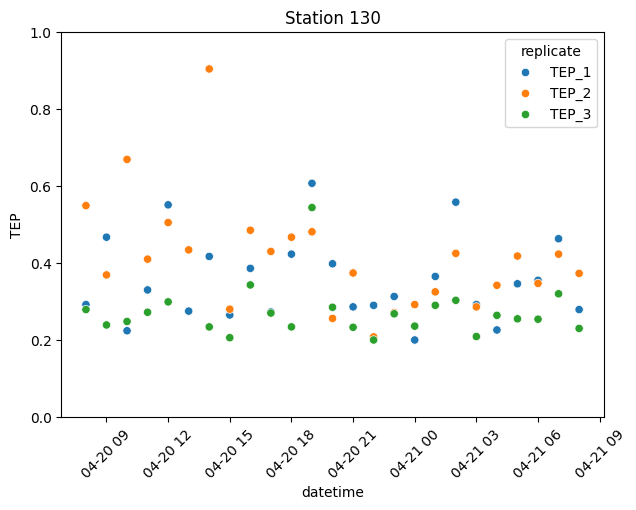

In [24]:
fig, ax = plt.subplots(figsize=(7, 5))

fig = sns.scatterplot(y='TEP', x='datetime', hue='replicate',
                      data=df_130)

# Adjust x axis labels
ax.tick_params(axis='x', rotation=45)

# Set y axis limits
ax.set_ylim(0, 1)

# Set title
ax.set_title('Station 130')

# Save figure
fig.figure.savefig('../figures/TEP_replicates_130.png', bbox_inches='tight')

Ok. It looks like there's some outliers to this data, which are exaggerated after using the formula. Before calculation, let's do an outlier test and remove those samples.

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_1219/4020698358.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(data_2['TEP'], bins=100, kde=False, ax=ax)


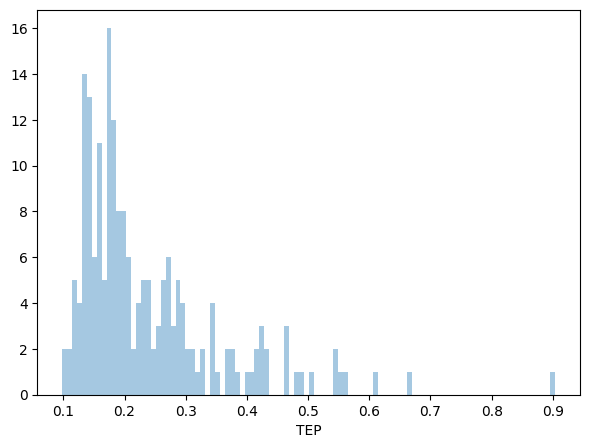

In [25]:
# Plot the distribution of the TEP values
fig, ax = plt.subplots(figsize=(7, 5))
fig = sns.distplot(data_2['TEP'], bins=100, kde=False, ax=ax)

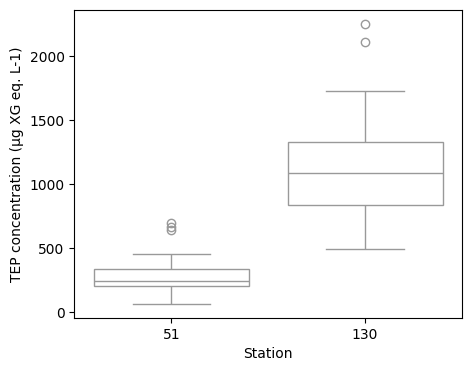

In [26]:
# Create boxplots of the TEP values per station
fig, ax = plt.subplots(figsize=(5, 4))
fig = sns.boxplot(x='station', y='TEP', data=data[~data['station'].isin(['W08', '48'])], color='white')

# Set y axis label
ax.set_ylabel('TEP concentration (µg XG eq. L-1)')

# Set x axis label
ax.set_xlabel('Station')

# Save figure
fig.figure.savefig('../figures/TEP_boxplot.svg', bbox_inches='tight')

# Display the boxplot
plt.show()

In [27]:
# Statistical analysis to check if the TEP values are significantly different between the two stations
## Perform a t-test
t_stat, p_val = stats.ttest_ind(data[data['station'] == '130']['TEP'], data[data['station'] == '51']['TEP'])

print(f'The t-statistic is {t_stat} and the p-value is {p_val}')

The t-statistic is 8.083653668375996 and the p-value is 3.0600749386319516e-10


In [28]:
## Load the combined data for more detailed analysis
data = pd.read_csv('../data/samples_env.csv')
data.head()

,Station,StationPrefix,StationSuffix,Latitude,Longitude,Date,day_moment,day_length,Temperature,Salinity,...,Fluorescence,NH4,NO2,NO3,NOX,PO4,Si,TEP,sea_surface_height_above_sea_level,surface_baroclinic_sea_water_velocity
0,51_1,51,1,51.531661,3.182804,2023-04-18 11:11:00,Day,14.033333,9.9259,32.513,...,2.001848,3.08,0.16,6.96,7.12,0.10,7.24,65.846667,1.817039,0.737313
1,51_2,51,2,51.533392,3.184085,2023-04-18 12:05:00,Day,14.033333,9.9105,32.683,...,NaN,3.45,0.15,6.19,6.34,0.14,7.06,167.438667,2.129479,0.933577
2,51_3,51,3,51.532763,3.185113,2023-04-18 13:08:00,Day,14.033333,9.9231,32.661,...,1.472718,3.53,0.15,6.13,6.28,0.12,7.13,210.709333,1.852063,0.844862
3,51_4,51,4,51.533244,3.184346,2023-04-18 14:05:00,Day,14.033333,9.9013,32.703,...,1.423711,NaN,NaN,NaN,NaN,NaN,NaN,255.861333,1.210772,0.645538
4,51_5,51,5,51.533104,3.183575,2023-04-18 15:07:00,Day,14.033333,9.9336,32.590,...,1.315579,4.18,0.15,6.54,6.69,0.15,7.53,223.878667,0.336479,0.489504


In [29]:
# Check the date ranges for every day_moment
time_checks = data[['Date', 'day_moment']].groupby('day_moment').agg(['min', 'max'])
time_checks

Date                     
                                       min                  max
day_moment                                                     
Astronomical twilight  2023-04-19 02:59:00  2023-04-21 03:00:00
Civil twilight         2023-04-18 19:11:00  2023-04-20 18:59:00
Day                    2023-04-18 11:11:00  2023-04-21 08:00:00
Nautical twilight      2023-04-18 20:05:00  2023-04-21 04:00:00
Night                  2023-04-18 21:07:00  2023-04-21 02:00:00

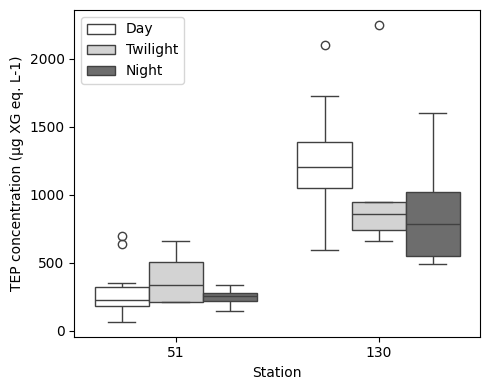

In [31]:
# Define custom color palette
custom_palette = {'Night': '#6d6d6d', 'Twilight': 'lightgrey', 'Day': 'white'}

# Combine twilight moments into one category
data['day_moment_grouped'] = data['day_moment'].replace(['Civil twilight', 'Nautical twilight', 'Astronomical twilight'], 'Twilight')

# Plot TEP boxplot at each station, at day moments
fig, ax = plt.subplots(figsize=(5, 4))
fig = sns.boxplot(x='StationPrefix', y='TEP', hue='day_moment_grouped', data=data, palette=custom_palette)

# Set y axis label
ax.set_ylabel('TEP concentration (µg XG eq. L-1)')
# Set x axis label
ax.set_xlabel('Station')
# Set legend title
ax.legend(title=None)

# Save figure
plt.tight_layout()
fig.figure.savefig('../figures/TEP_boxplot_day_moment.svg', bbox_inches='tight')
fig.figure.savefig('../figures/TEP_boxplot_day_moment.png', bbox_inches='tight')

# Display the boxplot
plt.show()

Shapiro-Wilk test for normality:
Statistic: 0.8964165449142456, p-value: 0.00063783407676965


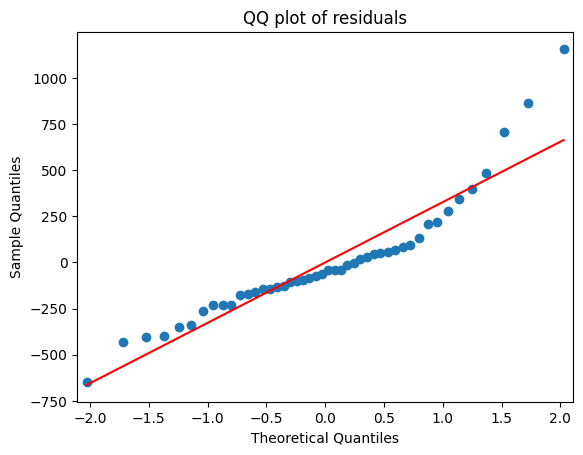


Levene's test for homogeneity of variance:
Statistic: 1.147223090512367, p-value: 0.3270433228739451


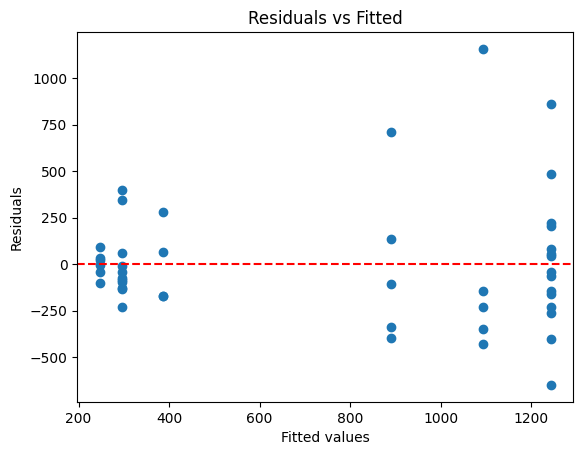

In [21]:
# Fit the ANOVA model
model = ols('TEP ~ C(StationPrefix) * C(day_moment_grouped)', data=data).fit()

# Residuals of the model
residuals = model.resid

### 1. Check Normality of Residuals ###
# Shapiro-Wilk Test
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test for normality:")
print(f"Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")

# Plot the QQ plot
qqplot(residuals, line='s')
plt.title('QQ plot of residuals')
plt.show()

# If the Shapiro-Wilk p-value is > 0.05, the residuals are normally distributed.
# In the QQ plot, the points should closely follow the line.

### 2. Check Homogeneity of Variance (Levene's Test) ###
# Levene's test for homogeneity of variance
levene_test = stats.levene(data['TEP'][data['day_moment_grouped'] == 'Day'],
                           data['TEP'][data['day_moment_grouped'] == 'Twilight'],
                           data['TEP'][data['day_moment_grouped'] == 'Night'])

print("\nLevene's test for homogeneity of variance:")
print(f"Statistic: {levene_test.statistic}, p-value: {levene_test.pvalue}")

# If Levene’s test p-value is > 0.05, variances are equal (homoscedasticity).

### 3. Plot Residuals to Check for Homoscedasticity ###
# Plot residuals vs fitted values
fitted_values = model.fittedvalues

plt.scatter(fitted_values, residuals)
plt.axhline(0, linestyle='--', color='r')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# Residuals should scatter randomly around 0. No clear pattern should be visible.

In [22]:
# Perform two-way ANOVA
model = ols('TEP ~ C(StationPrefix) * C(day_moment_grouped)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Display ANOVA table
print(anova_table)

                                              sum_sq    df          F  \
C(StationPrefix)                        7.701968e+06   1.0  62.527633   
C(day_moment_grouped)                   3.141430e+05   2.0   1.275169   
C(StationPrefix):C(day_moment_grouped)  2.153194e+05   2.0   0.874024   
Residual                                4.927081e+06  40.0        NaN   

                                              PR(>F)  
C(StationPrefix)                        1.055772e-09  
C(day_moment_grouped)                   2.904957e-01  
C(StationPrefix):C(day_moment_grouped)  4.250854e-01  
Residual                                         NaN  


In [23]:
# Kruskal-Wallis test for day moment
kruskal_test_day = stats.kruskal(data['TEP'][data['day_moment_grouped'] == 'Day'],
                                 data['TEP'][data['day_moment_grouped'] == 'Twilight'],
                                 data['TEP'][data['day_moment_grouped'] == 'Night'])

print(kruskal_test_day)

KruskalResult(statistic=2.0997845817457232, pvalue=0.34997544263059654)


In [24]:
# Kruskal-Wallis test for stations
kruskal_test_station = stats.kruskal(data['TEP'][data['StationPrefix'] == 51],
                                     data['TEP'][data['StationPrefix'] == 130])

print(kruskal_test_station)

KruskalResult(statistic=30.760972644376892, pvalue=2.918488655045497e-08)


In [25]:
# Apply log transformation to TEP values
data['log_TEP'] = np.log(data['TEP'] + 1)  # Add 1 to avoid log(0)

# Re-run the two-way ANOVA on transformed data
model_log = ols('log_TEP ~ C(StationPrefix) * C(day_moment_grouped)', data=data).fit()
anova_table_log = sm.stats.anova_lm(model_log, typ=2)

print(anova_table_log)

                                           sum_sq    df          F  \
C(StationPrefix)                        21.722977   1.0  99.646287   
C(day_moment_grouped)                    0.423758   2.0   0.971919   
C(StationPrefix):C(day_moment_grouped)   0.564231   2.0   1.294103   
Residual                                 8.720035  40.0        NaN   

                                              PR(>F)  
C(StationPrefix)                        2.032503e-12  
C(day_moment_grouped)                   3.871119e-01  
C(StationPrefix):C(day_moment_grouped)  2.853730e-01  
Residual                                         NaN  


Shapiro-Wilk test for normality:
Statistic: 0.9685007333755493, p-value: 0.24346719682216644


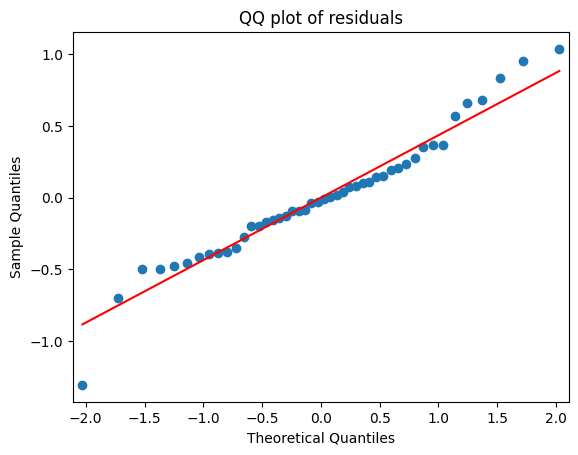


Levene's test for homogeneity of variance:
Statistic: 1.147223090512367, p-value: 0.3270433228739451


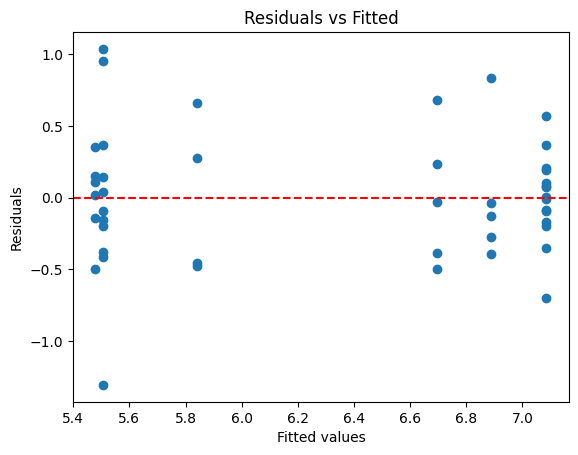

In [26]:
# Residuals of the model_log
residuals = model_log.resid

### 1. Check Normality of Residuals ###
# Shapiro-Wilk Test
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test for normality:")
print(f"Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")

# Plot the QQ plot
qqplot(residuals, line='s')
plt.title('QQ plot of residuals')
plt.show()

# If the Shapiro-Wilk p-value is > 0.05, the residuals are normally distributed.
# In the QQ plot, the points should closely follow the line.

### 2. Check Homogeneity of Variance (Levene's Test) ###
# Levene's test for homogeneity of variance
levene_test = stats.levene(data['TEP'][data['day_moment_grouped'] == 'Day'],
                           data['TEP'][data['day_moment_grouped'] == 'Twilight'],
                           data['TEP'][data['day_moment_grouped'] == 'Night'])

print("\nLevene's test for homogeneity of variance:")
print(f"Statistic: {levene_test.statistic}, p-value: {levene_test.pvalue}")

# If Levene’s test p-value is > 0.05, variances are equal (homoscedasticity).

### 3. Plot Residuals to Check for Homoscedasticity ###
# Plot residuals vs fitted values
fitted_values = model_log.fittedvalues

plt.scatter(fitted_values, residuals)
plt.axhline(0, linestyle='--', color='r')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# Residuals should scatter randomly around 0. No clear pattern should be visible.

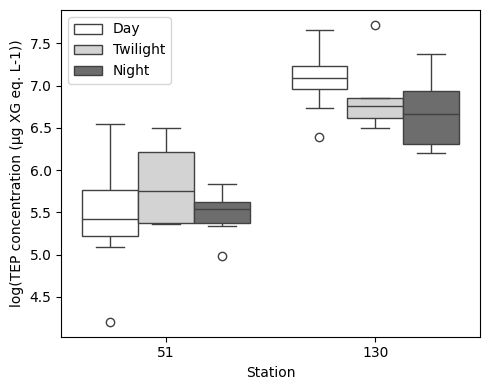

In [27]:
# Plot TEP boxplot at each station, at day moments
fig, ax = plt.subplots(figsize=(5, 4))
fig = sns.boxplot(x='StationPrefix', y='log_TEP', hue='day_moment_grouped', data=data, palette=custom_palette)

# Set y axis label
ax.set_ylabel('log(TEP concentration (µg XG eq. L-1))')
# Set x axis label
ax.set_xlabel('Station')
# Set legend title
ax.legend(title=None)

# Save figure
plt.tight_layout()
fig.figure.savefig('../figures/TEP_log_boxplot_day_moment.svg', bbox_inches='tight')

# Display the boxplot
plt.show()

Now, let's model if there's a linear relationship between the TEP concentration and the activity of *Phaeocystis globosa*. Let's start by loading the TPL quantification data.

In [28]:
phaeo_TPM_130 = pd.read_csv('../data/analysis/phaeocystis_bin_tpm_130.csv')
phaeo_TPM_130.columns = ['Station', 'Phaeo_TPM']
phaeo_TPL_130 = pd.read_csv('../data/analysis/phaeocystis_bin_tpl_130.csv')
phaeo_TPL_130.columns = ['Station', 'Phaeo_TPL']

phaeo_TPM_51 = pd.read_csv('../data/analysis/phaeocystis_bin_tpm_51.csv')
phaeo_TPM_51.columns = ['Station', 'Phaeo_TPM']
phaeo_TPL_51 = pd.read_csv('../data/analysis/phaeocystis_bin_tpl_51.csv')
phaeo_TPL_51.columns = ['Station', 'Phaeo_TPL']

# Combine the data for both stations into a single dataframe
phaeo_TPM_combined = pd.concat([phaeo_TPM_130, phaeo_TPM_51], ignore_index=True)
phaeo_TPL_combined = pd.concat([phaeo_TPL_130, phaeo_TPL_51], ignore_index=True)

# Combine the data with the TEP data
data = pd.merge(data, phaeo_TPM_combined, on='Station')
data = pd.merge(data, phaeo_TPL_combined, on='Station')

data['log_Phaeo_TPL'] = np.log(data['Phaeo_TPL'])

In [29]:
data.head()

,Station,StationPrefix,StationSuffix,Latitude,Longitude,Date,day_moment,day_length,Temperature,Salinity,...,PO4,Si,TEP,sea_surface_height_above_sea_level,surface_baroclinic_sea_water_velocity,day_moment_grouped,log_TEP,Phaeo_TPM,Phaeo_TPL,log_Phaeo_TPL
0,51_1,51,1,51.531661,3.182804,2023-04-18 11:11:00,Day,14.033333,9.9259,32.513,...,0.10,7.24,65.846667,1.817039,0.737313,Day,4.202401,20376.55900,4.264275e+06,15.265783
1,51_2,51,2,51.533392,3.184085,2023-04-18 12:05:00,Day,14.033333,9.9105,32.683,...,0.14,7.06,167.438667,2.129479,0.933577,Day,5.126572,11698.43500,3.152965e+06,14.963854
2,51_3,51,3,51.532763,3.185113,2023-04-18 13:08:00,Day,14.033333,9.9231,32.661,...,0.12,7.13,210.709333,1.852063,0.844862,Day,5.355214,7138.62800,1.720647e+06,14.358211
3,51_4,51,4,51.533244,3.184346,2023-04-18 14:05:00,Day,14.033333,9.9013,32.703,...,NaN,NaN,255.861333,1.210772,0.645538,Day,5.548536,2299.25800,4.877061e+05,13.097468
4,51_5,51,5,51.533104,3.183575,2023-04-18 15:07:00,Day,14.033333,9.9336,32.590,...,0.15,7.53,223.878667,0.336479,0.489504,Day,5.415561,428.73343,6.699041e+04,11.112305


<Axes: xlabel='Phaeo_TPL', ylabel='Count'>

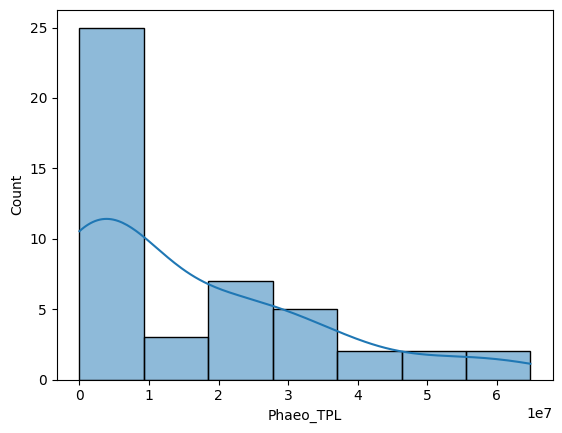

In [30]:
sns.histplot(data['Phaeo_TPL'], kde=True)

<Axes: xlabel='log_Phaeo_TPL', ylabel='Count'>

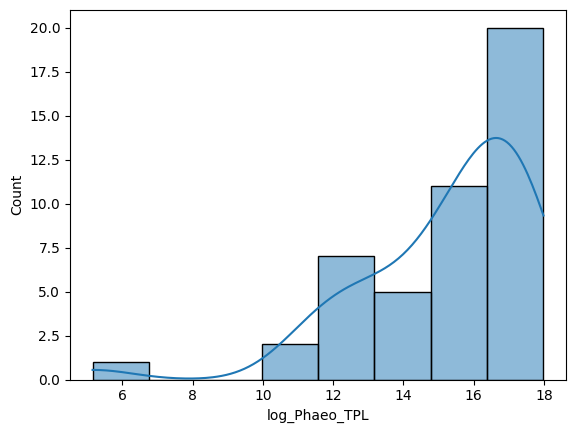

In [31]:
sns.histplot(data['log_Phaeo_TPL'], kde=True)

<Axes: xlabel='TEP', ylabel='Count'>

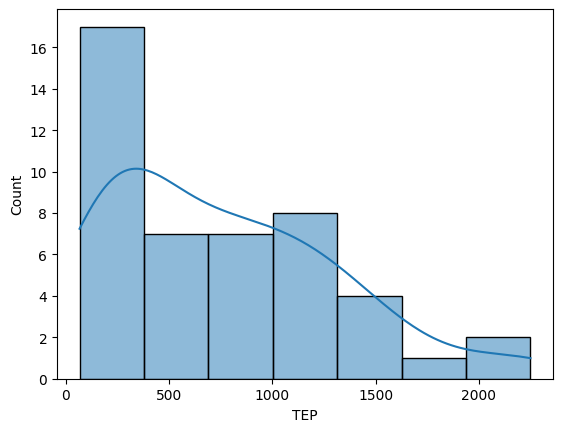

In [32]:
sns.histplot(data['TEP'], kde=True)

<Axes: xlabel='log_TEP', ylabel='Count'>

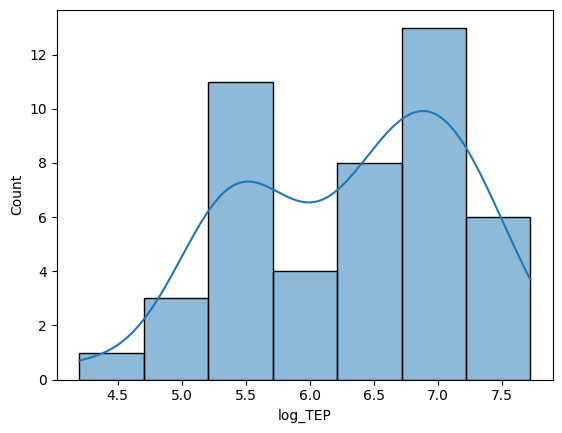

In [33]:
sns.histplot(data['log_TEP'], kde=True)

<Axes: xlabel='Phaeo_TPL', ylabel='TEP'>

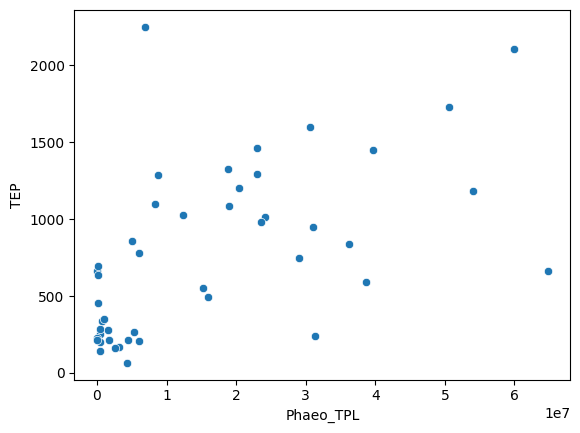

In [34]:
sns.scatterplot(x=data['Phaeo_TPL'], y=data['TEP'])


<Axes: xlabel='Phaeo_TPL', ylabel='log_TEP'>

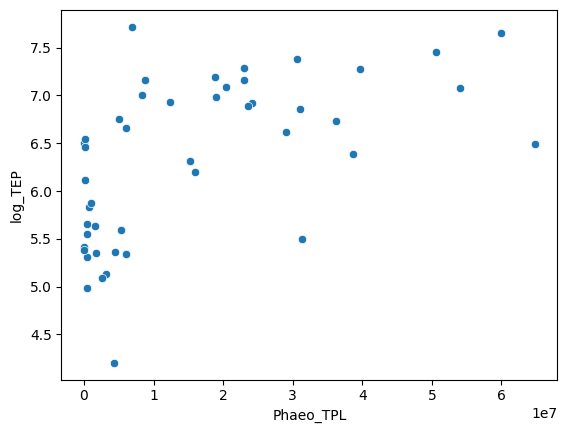

In [35]:
sns.scatterplot(x=data['Phaeo_TPL'], y=data['log_TEP'])

<Axes: xlabel='log_Phaeo_TPL', ylabel='log_TEP'>

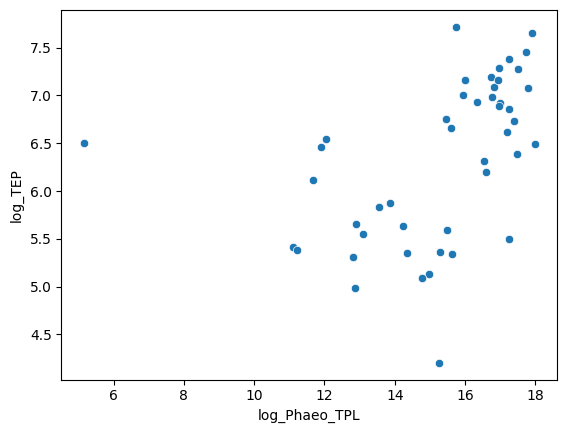

In [36]:
sns.scatterplot(x=data['log_Phaeo_TPL'], y=data['log_TEP'])

In [37]:
# Test if there is a linear relationship between TEP and Phaeocystis TPL
# Add a constant to the predictor variable (TEP)
X = sm.add_constant(data['Phaeo_TPL'])  # Add intercept term
Y = data['TEP']

# Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Output the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    TEP   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     20.74
Date:                Fri, 14 Mar 2025   Prob (F-statistic):           4.14e-05
Time:                        13:12:18   Log-Likelihood:                -346.05
No. Observations:                  46   AIC:                             696.1
Df Residuals:                      44   BIC:                             699.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        479.2559     90.983      5.268      0.0

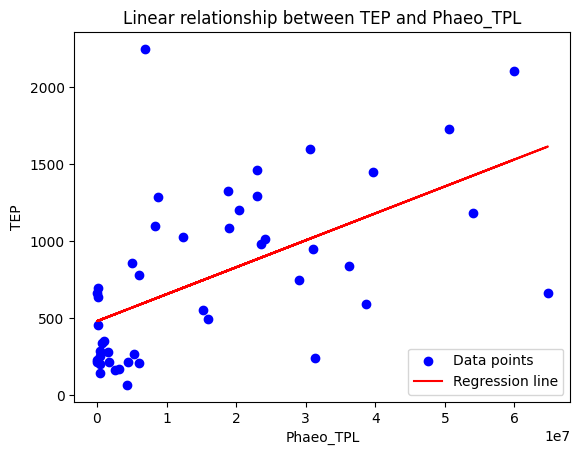

In [38]:
# Visualize the relationship between TEP and Phaeocystis TPL
# Scatter plot with regression line
plt.scatter(data['Phaeo_TPL'], data['TEP'], color='blue', label='Data points')
plt.plot(data['Phaeo_TPL'], model.fittedvalues, color='red', label='Regression line')
plt.xlabel('Phaeo_TPL')
plt.ylabel('TEP')
plt.title('Linear relationship between TEP and Phaeo_TPL')
plt.legend()
plt.show()

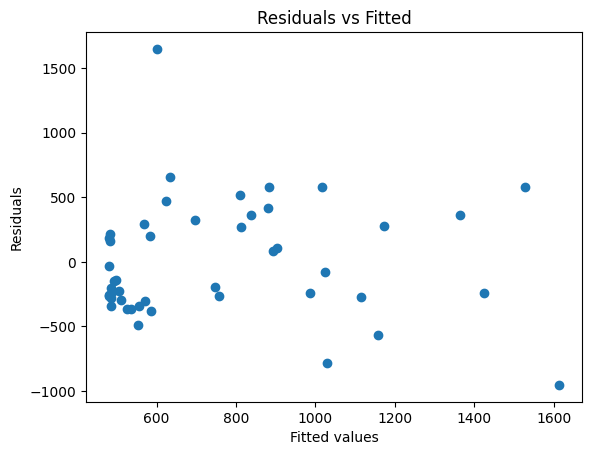

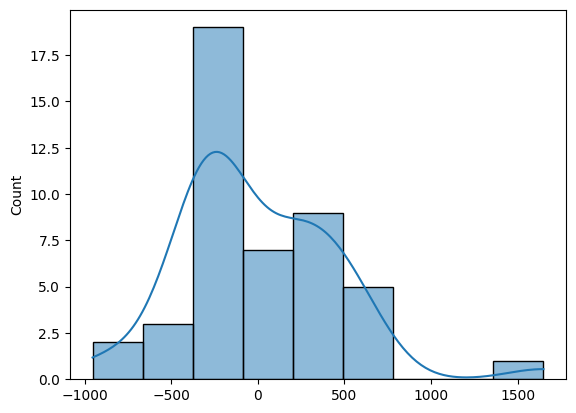

In [39]:
# Plot residuals vs fitted values
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

# Check normality of residuals
sns.histplot(model.resid, kde=True)
plt.show()

In [40]:
# Mixed-effects model controlling for random effects by station
model = smf.mixedlm("TEP ~ Phaeo_TPL", data, groups=data["StationPrefix"])
mixed_fit = model.fit()

# Output the summary of the model
print(mixed_fit.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: TEP        
No. Observations:  46      Method:             REML       
No. Groups:        2       Scale:              125527.5736
Min. group size:   21      Log-Likelihood:     -342.9355  
Max. group size:   25      Converged:          Yes        
Mean group size:   23.0                                   
----------------------------------------------------------
            Coef.    Std.Err.   z   P>|z|  [0.025  0.975] 
----------------------------------------------------------
Intercept    673.226  390.683 1.723 0.085 -92.499 1438.951
Phaeo_TPL      0.000    0.000 0.800 0.424  -0.000    0.000
Group Var 292609.327 1221.261                             



/opt/homebrew/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


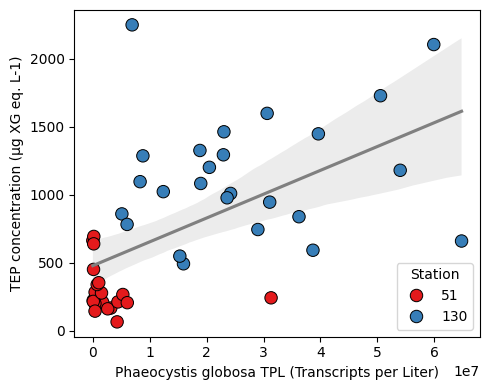

In [41]:
# Create the scatter plot with regression lines
plt.figure(figsize=(5, 4))

# Plot regression line for overall data, with 95% confidence interval
sns.regplot(x='Phaeo_TPL', y='TEP', data=data, scatter=False, color='grey', ci=95)

# Scatter plot for TEP vs Phaeo_TPL, colored by StationPrefix
sns.scatterplot(x='Phaeo_TPL', y='TEP', hue='StationPrefix', data=data, s=80, edgecolor='k', palette='Set1', legend=True)

# Customize the plot
plt.xlabel('Phaeocystis globosa TPL (Transcripts per Liter)')
plt.ylabel('TEP concentration (µg XG eq. L-1)')
plt.legend(title='Station', loc='best')

# Display the plot
plt.tight_layout()
# Save the plot
plt.savefig('../figures/TEP_Phaeo_TPL_regression.svg', bbox_inches='tight')
plt.show()

## Primary production
We'll repeat the analysis but now on the PP estimates from the labstaf. 

In [42]:
## Read in primary production data
PP_data = pd.read_csv('../data/raw/LabSTAF/labstaf_combined_data.csv')
## Combine Station and Sample columns into one station_sample column
PP_data['Station'] = PP_data['Station'].astype(str) + '_' + PP_data['Sample'].astype(str)

# Merge PP_data with env and transcript data
data = pd.merge(PP_data, data, on=['Station'], how='inner')

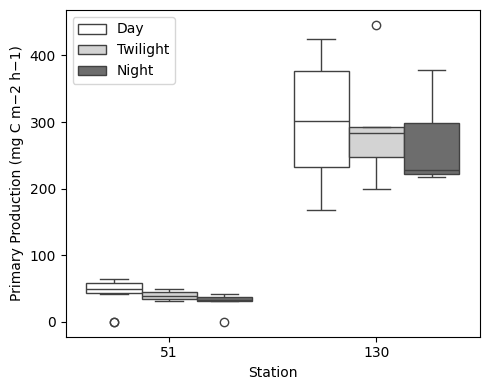

In [45]:
# Plot TEP boxplot at each station, at day moments
fig, ax = plt.subplots(figsize=(5, 4))
fig = sns.boxplot(x='StationPrefix', y='PP', hue='day_moment_grouped', data=data, palette=custom_palette)

# Set y axis label
ax.set_ylabel('Primary Production (mg C m−2 h−1)')
# Set x axis label
ax.set_xlabel('Station')
# Set legend title
ax.legend(title=None)

# Save figure
plt.tight_layout()
fig.figure.savefig('../figures/PP_boxplot_day_moment.svg', bbox_inches='tight')

# Display the boxplot
plt.show()

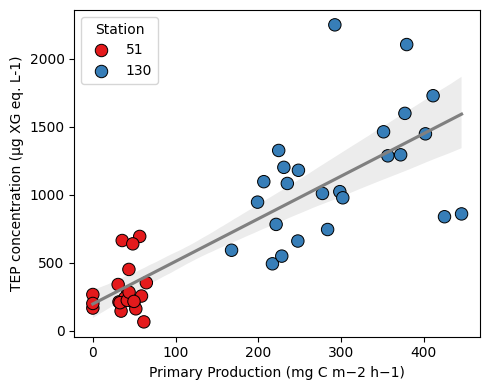

In [46]:
# Create the scatter plot with regression lines
plt.figure(figsize=(5, 4))

# Plot regression line for overall data, with 95% confidence interval
sns.regplot(x='PP', y='TEP', data=data, scatter=False, color='grey', ci=95)

# Scatter plot for TEP vs PP, colored by StationPrefix
sns.scatterplot(x='PP', y='TEP', hue='StationPrefix', data=data, s=80, edgecolor='k', palette='Set1', legend=True)

# Customize the plot
plt.xlabel('Primary Production (mg C m−2 h−1)')
plt.ylabel('TEP concentration (µg XG eq. L-1)')
plt.legend(title='Station', loc='best')

# Display the plot
plt.tight_layout()
# Save the plot
plt.savefig('../figures/TEP_PP_regression.svg', bbox_inches='tight')
plt.show()

In [47]:
data.head()

,Filename,Station,Sample,Datetime,Blank,Alpha,Beta,Ek,EkBeta,rPm,...,PO4,Si,TEP,sea_surface_height_above_sea_level,surface_baroclinic_sea_water_velocity,day_moment_grouped,log_TEP,Phaeo_TPM,Phaeo_TPL,log_Phaeo_TPL
0,Spring_130_20042023_st1.txt,130_1,1,2023-04-20 09:52:00,0,0.4147,0.03988,212,232,78.93,...,0.05,13.20,1286.832000,-1.802973,0.543319,Day,7.160715,62425.375,8.797049e+06,15.989927
1,Spring_130_20042023_st10.txt,130_10,10,2023-04-20 18:53:00,0,0.3883,0.02569,308,749,103.90,...,0.06,12.24,1010.276000,-0.966200,0.699498,Day,6.918968,106564.230,2.421051e+07,17.002297
2,Spring_130_20042023_st11.txt,130_11,11,2023-04-20 20:02:00,0,0.3958,0.05600,312,434,100.10,...,0.07,11.08,1294.357333,-1.816134,0.673483,Day,7.166542,113123.670,2.294574e+07,16.948643
3,Spring_130_20042023_st12.txt,130_12,12,2023-04-20 20:58:00,0,0.3992,0.05914,271,71,104.30,...,0.08,13.22,2250.074667,-2.102734,0.631503,Twilight,7.719163,23810.021,6.904549e+06,15.747691
4,Spring_130_20042023_st13.txt,130_13,13,2023-04-20 21:45:00,0,0.3864,NaN,297,0,115.00,...,0.09,13.93,946.310667,-1.620326,0.664108,Twilight,6.853627,85652.305,3.108437e+07,17.252216


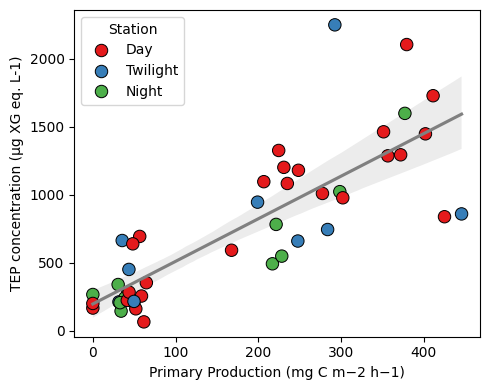

In [48]:
# Create the scatter plot with regression lines
plt.figure(figsize=(5, 4))

# Plot regression line for overall data, with 95% confidence interval
sns.regplot(x='PP', y='TEP', data=data, scatter=False, color='grey', ci=95)

# Scatter plot for TEP vs PP, colored by StationPrefix
sns.scatterplot(x='PP', y='TEP', hue='day_moment_grouped', data=data, s=80, edgecolor='k', palette='Set1', legend=True)

# Customize the plot
plt.xlabel('Primary Production (mg C m−2 h−1)')
plt.ylabel('TEP concentration (µg XG eq. L-1)')
plt.legend(title='Station', loc='best')

# Display the plot
plt.tight_layout()
# Save the plot
plt.savefig('../figures/TEP_PP_regression_daymoment.svg', bbox_inches='tight')
plt.show()

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_49097/3931023324.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='PP', y='TEP', size='sea_surface_height_above_sea_level', data=data, s=80, edgecolor='k', palette='Set1', legend=True)


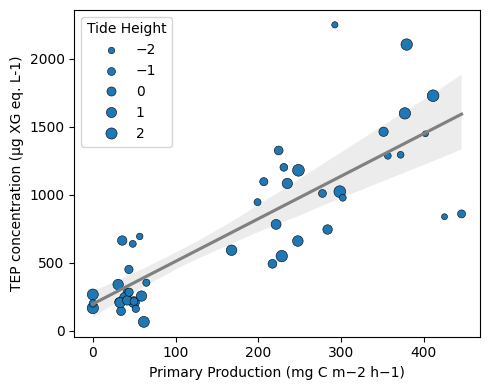

In [49]:
# Create the scatter plot with regression lines
plt.figure(figsize=(5, 4))

# Plot regression line for overall data, with 95% confidence interval
sns.regplot(x='PP', y='TEP', data=data, scatter=False, color='grey', ci=95)

# Scatter plot for TEP vs PP, colored by StationPrefix
sns.scatterplot(x='PP', y='TEP', size='sea_surface_height_above_sea_level', data=data, s=80, edgecolor='k', palette='Set1', legend=True)

# Customize the plot
plt.xlabel('Primary Production (mg C m−2 h−1)')
plt.ylabel('TEP concentration (µg XG eq. L-1)')
plt.legend(title='Tide Height', loc='best')

# Display the plot
plt.tight_layout()
# Save the plot
plt.savefig('../figures/TEP_PP_regression_tide.svg', bbox_inches='tight')
plt.show()

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_49097/776981287.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='PP', y='TEP', size='sea_surface_height_above_sea_level', data=data[data['StationPrefix'] == 130], s=80, edgecolor='k', palette='Set1', legend=True)


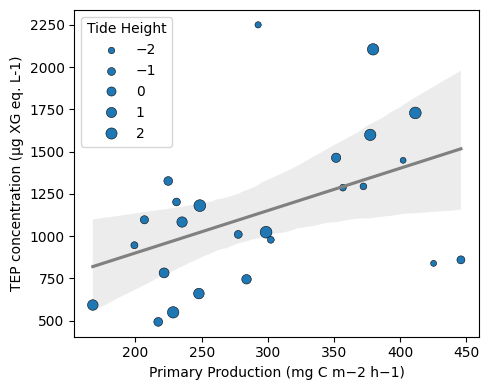

In [50]:
# Create the scatter plot with regression lines
plt.figure(figsize=(5, 4))

# Plot regression line for overall data, with 95% confidence interval
sns.regplot(x='PP', y='TEP', data=data[data['StationPrefix'] == 130], scatter=False, color='grey', ci=95)

# Scatter plot for TEP vs PP, colored by StationPrefix
sns.scatterplot(x='PP', y='TEP', size='sea_surface_height_above_sea_level', data=data[data['StationPrefix'] == 130], s=80, edgecolor='k', palette='Set1', legend=True)

# Customize the plot
plt.xlabel('Primary Production (mg C m−2 h−1)')
plt.ylabel('TEP concentration (µg XG eq. L-1)')
plt.legend(title='Tide Height', loc='best')

# Display the plot
plt.tight_layout()
# Save the plot
plt.savefig('../figures/TEP_PP_regression_tide_13o.svg', bbox_inches='tight')
plt.show()

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_49097/161801107.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='PP', y='TEP', size='Oxygen', data=data[data['StationPrefix'] == 130], s=80, edgecolor='k', palette='Set1', legend=True)


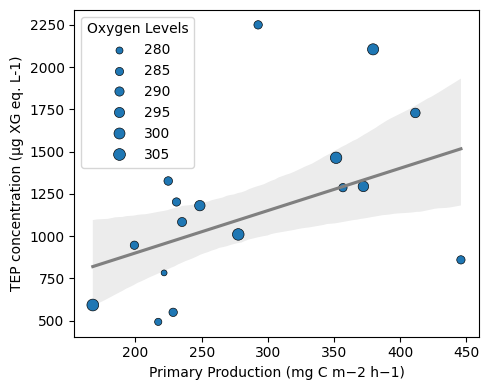

In [51]:
# Create the scatter plot with regression lines
plt.figure(figsize=(5, 4))

# Plot regression line for overall data, with 95% confidence interval
sns.regplot(x='PP', y='TEP', data=data[data['StationPrefix'] == 130], scatter=False, color='grey', ci=95)

# Scatter plot for TEP vs PP, colored by StationPrefix
sns.scatterplot(x='PP', y='TEP', size='Oxygen', data=data[data['StationPrefix'] == 130], s=80, edgecolor='k', palette='Set1', legend=True)

# Customize the plot
plt.xlabel('Primary Production (mg C m−2 h−1)')
plt.ylabel('TEP concentration (µg XG eq. L-1)')
plt.legend(title='Oxygen Levels', loc='best')

# Display the plot
plt.tight_layout()
# Save the plot
plt.savefig('../figures/TEP_PP_regression_oxygen.svg', bbox_inches='tight')
plt.show()

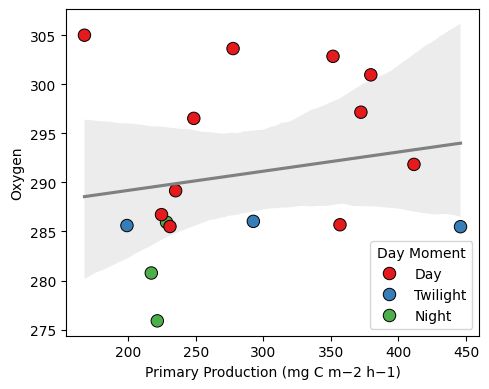

In [52]:
# Create the scatter plot with regression lines
plt.figure(figsize=(5, 4))

# Plot regression line for overall data, with 95% confidence interval
sns.regplot(x='PP', y='Oxygen', data=data[data['StationPrefix'] == 130], scatter=False, color='grey', ci=95)

# Scatter plot for TEP vs PP, colored by StationPrefix
sns.scatterplot(x='PP', y='Oxygen', hue='day_moment_grouped', data=data[data['StationPrefix'] == 130], s=80, edgecolor='k', palette='Set1', legend=True)

# Customize the plot
plt.xlabel('Primary Production (mg C m−2 h−1)')
plt.ylabel('Oxygen')
plt.legend(title='Day Moment', loc='best')

# Display the plot
plt.tight_layout()
# Save the plot
plt.savefig('../figures/Oxygen_PP_regression_daymoment.svg', bbox_inches='tight')
plt.show()